# Modules and Constants

In [1]:
# Mathematical operations
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

# My own functions
from diffusion import *

# Box properties

Values are taken from the supporting information to the CNT-porins paper

In [2]:
# Number of lipids in the simulation
num_lip = [58,115,153,188,277,437,785]

box_data = [[4.07, 0.04, 10.22, 0.20],
            [5.76, 0.05, 9.38, 0.17 ],
            [6.75, 0.06, 8.23, 0.14 ],
            [7.45, 0.06, 8.98, 0.13 ],
            [9.14, 0.07, 8.64, 0.13 ],
            [11.52, 0.06, 8.51, 0.09 ],
            [15.44, 0.06, 8.45, 0.06 ]]

box_data = np.array(box_data)

avg_box_width  = box_data[:,0]
err_box_width  = box_data[:,1]
avg_box_height = box_data[:,2]
err_box_height = box_data[:,3]

# MSD and Diffusion Coefficients

In [3]:
init_num_lip = ['072','128','162','200','288','450','800'] # Files were named after the initial number of lipids (befor insertion of the CNT)

numblocks = np.array([5,4,4,5,3,4,3])
fitstart  = 400
fitend    = 700

In [4]:
msd = []
tau = []
dc  = []
err = []

for n_, nlip_ in enumerate(init_num_lip):
    
    # Get all the files for the current box size (=initial number of lipids)
    fstring  = 'simulations-CNTP/results-rotation/Rotation_CNT_popc'+nlip_+'-cnt1-arm-cooh-08-50-??.xvg'
    files    = !ls $fstring
    
    # Initialize time and rotation increment
    time = []
    drot = []
    
    # Go through all identified files,...
    for i_, f_ in enumerate(files):
        
        if i_>0: time_old = np.copy(time_new)
            
        # ... load all data from the current file,...
        data = np.loadtxt(f_,comments=['#','@']).T
        time_new = data[0]
        drot_new = data[1]
        
        # ... correct for overlapping trajectories, ...
        if i_>0:
            time_new_corr = time_new[time_new>time_old[-1]]
            drot_new_corr = drot_new[time_new>time_old[-1]]
        else:
            time_new_corr = time_new
            drot_new_corr = drot_new
            
        # ... append the corrected values, ...
        time.append(time_new_corr)
        drot.append(drot_new_corr)
        
    # .. and flatten the list of arrays.
    time = np.concatenate(time)
    drot = np.concatenate(drot)
    
    # overwrite the increments with their cumulative sum ( = total rotation in radians)
    rota = [np.cumsum(drot)] # [...] because it must be iterable in compute_dc(...)
    
    # Calculate MSD and diffusion coefficient with uncertainty
    totdc, diffcoeff, err_diffc, t, new_msd = compute_dc(time-time[0],rota,numblocks[n_],fitstart,fitend)
    
    # Append to the arrays
    msd.append(new_msd)
    tau.append(t)
    dc.append(totdc)
    err.append(err_diffc)
    
    # Give some statistics
    print( 'popc'+nlip_ )
    tot_time = time[-1]-time[0]
    print( 'Total simulation time:', tot_time, 'ps' )
    print( 'Total number of frames:', len(time) ) 
    ts = time[1]-time[0]
    print( 'Time step between two frames:', ts, 'ps' )
    blocksize = int( (len(time)-1)/numblocks[n_] )
    blocktime = blocksize*ts
    print( 'Size of one block:', blocksize, 'frames = ', blocktime, 'ps' )
    print( '-----' )

dc  = np.array(dc)
err = np.array(err)

popc072
Total simulation time: 413765.0 ps
Total number of frames: 41366
Time step between two frames: 10.0 ps
Size of one block: 8273 frames =  82730.0 ps
-----
popc128
Total simulation time: 346085.0 ps
Total number of frames: 34599
Time step between two frames: 10.0 ps
Size of one block: 8649 frames =  86490.0 ps
-----
popc162
Total simulation time: 277445.0 ps
Total number of frames: 27736
Time step between two frames: 10.0 ps
Size of one block: 6933 frames =  69330.0 ps
-----
popc200
Total simulation time: 413885.0 ps
Total number of frames: 41380
Time step between two frames: 10.0 ps
Size of one block: 8275 frames =  82750.0 ps
-----
popc288
Total simulation time: 240305.0 ps
Total number of frames: 24021
Time step between two frames: 10.0 ps
Size of one block: 8006 frames =  80060.0 ps
-----
popc450
Total simulation time: 261045.0 ps
Total number of frames: 26100
Time step between two frames: 10.0 ps
Size of one block: 6524 frames =  65240.0 ps
-----
popc800
Total simulation tim

In [5]:
np.savetxt('rotation_dc_cntp.dat',np.array([avg_box_width,dc,err]).T,header="box width [nm], diff. coeff. [rad^2/ps], err(diff. coeff.) [rad^2/ps]" ) 

# Fit

In [6]:
def dc_rot_theory(width,d0):
    radius=0.72
    return d0*(1 - np.pi*radius**2/width**2)

In [7]:
res_opt = sp.optimize.curve_fit(dc_rot_theory,avg_box_width,dc,sigma=err,absolute_sigma=True,p0=0.8)
dc0_opt = res_opt[0][0]
dc0_err = res_opt[1][0]
print(r"D_0: %2.11f +/- %2.11f rad^2/us"%(dc0_opt*1e6,dc0_err*1e6))

D_0: 0.79633856914 +/- 0.00000000352 rad^2/us


# Figure

In [8]:
cmap = plt.cm.viridis_r
labels = [ 'L = %3.1f nm'%e for e in avg_box_width ]

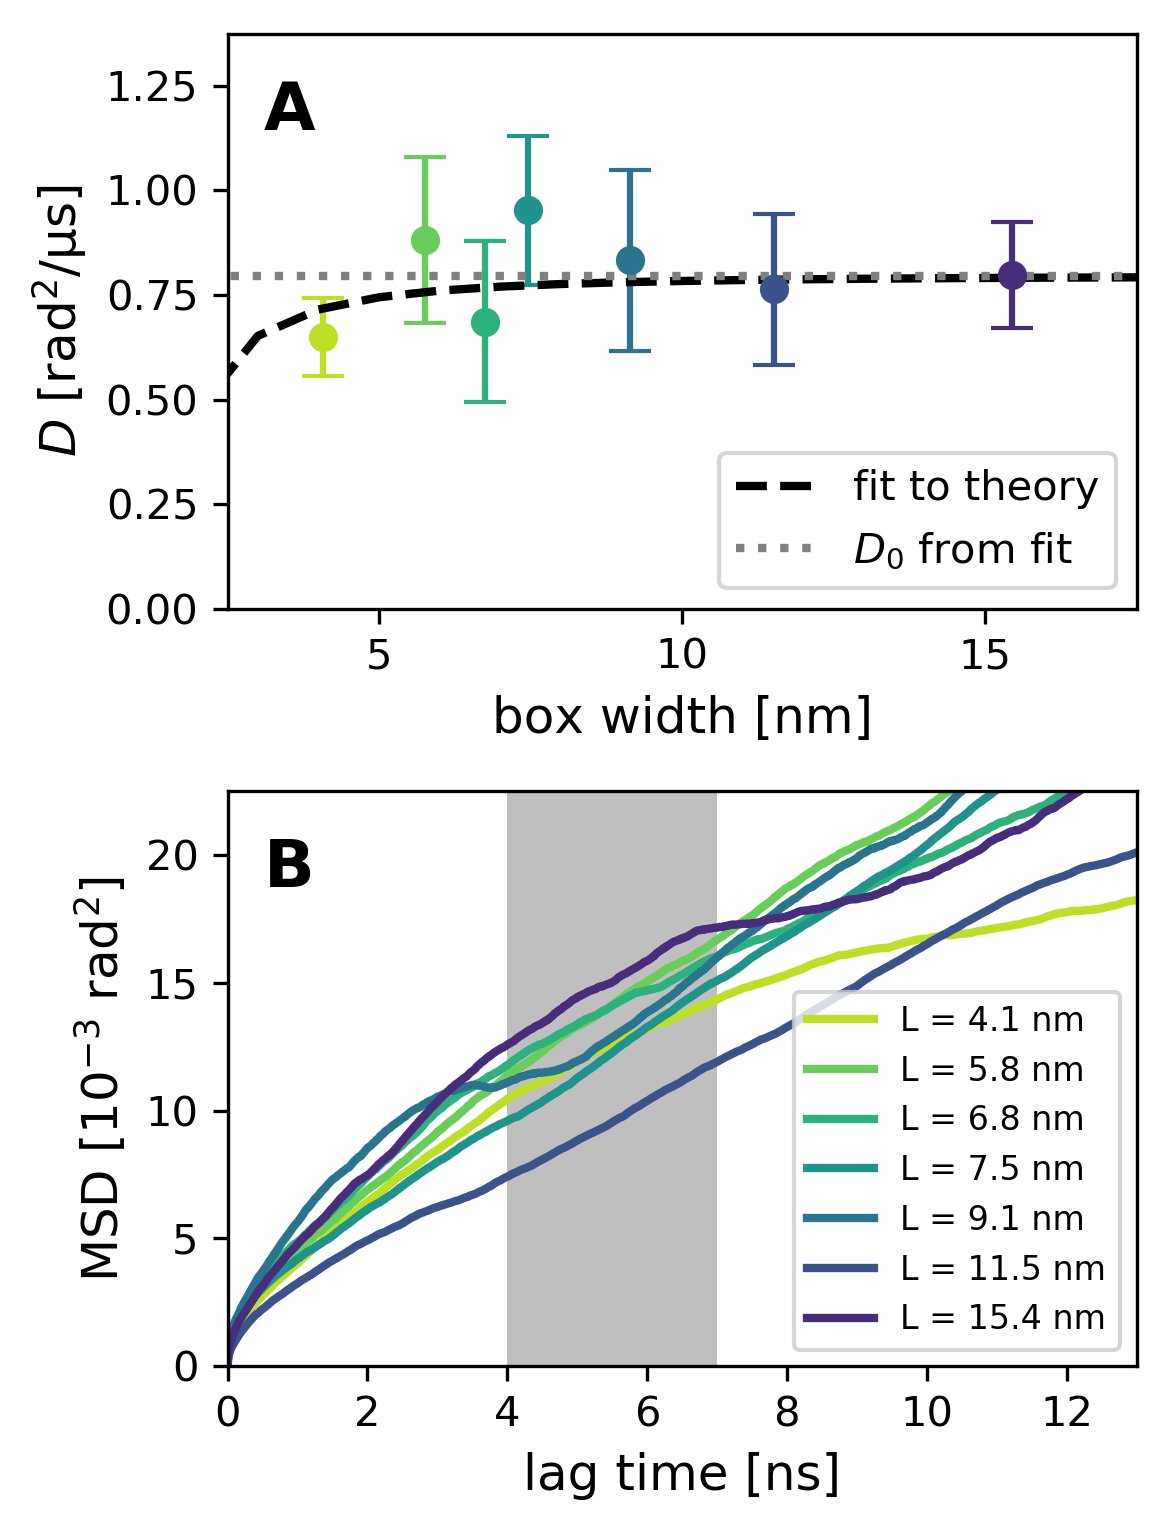

In [9]:
fig, ax = plt.subplots(2,1, figsize=plt.figaspect(1.3)*1.0, dpi=300)

# Diffusion coefficients
for i in range(len(avg_box_width)):
    ax[0].errorbar(avg_box_width[i],dc[i]*1e6,yerr=err[i]*1e6,ls='none',marker='o',capsize=5,c=cmap(0.1+0.9*float(i)/len(msd))) # ,xerr=err_box_width[i]
xax = np.arange(20)
ax[0].plot(xax[1:],dc_rot_theory(xax[1:],dc0_opt)*1e6,c='black',linestyle='--',lw=2,label='fit to theory')
ax[0].plot(xax,np.ones(len(xax))*dc0_opt*1e6,c='gray',linestyle=':',lw=2,label=r'$D_0$ from fit')
ax[0].set_xlim(2.5,17.5)
ax[0].set_xticks(np.arange(5,20,5.0))
ax[0].set_ylim(0,1.375)
ax[0].set_xlabel('box width [nm]',size=12)
ax[0].set_ylabel(r'$D$ [rad$^2$/$\mathrm{\mu}$s]',size=12)
#legend0 = ax[0].legend(loc=[1.1,0.65],fontsize=12)
legend0 = ax[0].legend(loc='lower right')

# MSD curves
for i,msdi in enumerate( msd ):
    ax[1].plot(tau[i]*1e-3,msdi*1e3,c=cmap(0.1+0.9*float(i)/len(msd)),lw=2,label=labels[i])
ax[1].axvspan(fitstart*ts*1e-3,fitend*ts*1e-3, facecolor='gray', alpha=0.5)
ax[1].set_xlim(0.0,13)
ax[1].set_ylim(0.0,22.5)
ax[1].set_xlabel('lag time [ns]',size=12)
ax[1].set_ylabel('MSD [$10^{-3}$ rad$^2$]',size=12)
#legend1 = ax[1].legend(loc=[1.1,0.0],fontsize=12)
legend1 = ax[1].legend(loc='best',fontsize=8)

# Panel labels
ax[0].text(0.04, 0.92, 'A', transform=ax[0].transAxes, fontsize=16, fontweight='bold', va='top')
ax[1].text(0.04, 0.92, 'B', transform=ax[1].transAxes, fontsize=16, fontweight='bold', va='top')

fig.tight_layout()

fig.savefig('rotational_diffusion_CNTP.pdf', bbox_extra_artists=(legend0,legend1), bbox_inches='tight', dpi=300)